In [1]:
"""
Importing in requirements for SVGP Pytorch
"""
import tqdm
import math
import torch
import gpytorch

"""
Importing in libraries for SGD-SS-GP
"""
import numpy as np
from functools import partial
import time
from IPython.display import clear_output
import inspect
import matplotlib.pyplot as plt

# Make plots inline
%matplotlib inline

"""
Importing algorithm functions
"""
import os
os.chdir('C:/Users/hughw/Documents/MSC project/GP algorithms/Master function files')
from GP_funcs_ZTMFSS import kernel_funcs
from GP_funcs_ZTMFSS import model_funcs
from GP_funcs_ZTMFSS import draw_GP
from GP_funcs_ZTMFSS import fit
from GP_funcs_ZTMFSS import diagnostics
from GP_funcs_ZTMFSS import simulations
from functools import partial
os.chdir('C:/Users/hughw/Documents/MSC project/Simulation results')

In [22]:
"""
Model run settings
"""
dlist = [10,100, 1000, 10000]
minibatch=256
nn_fraction = 1 # toggle
test_fraction = 1 # toggle
NNpred=True
nns=256
learn_rate = 0.025
sampling_strat = "nn"
min_VBEM_iter = 5
max_VBEM_iter = 10
gp_iters = 100
kern = kernel_funcs.gaussian
grad_kern = kernel_funcs.grad_gaussian
post_var = False
post_cov = False
train_largest = True
MC=100
learn_rate_mult = 1
spike = 1e+4
scale_values = 2**np.linspace(np.log2(100),-np.log2(100),11)

MSE_hyperopt=True

"""
Simulation settings
"""
n = 10000 # toggle
ntrain = n
ntest = 10000
q=2
corrzz=0.5
corrxz=0.5
r2=0.75
lin = False
block_corr = False
ntrial = 1

"""
Objects to store results
"""
names = ["SSVGP256","SSVGP128","SSVGP64"]
nmodel = len(names)
Lengthscales = []
Lambdas = []
Predictions = []
MSerrors_Y = []
MSerrors_F = []
Training_times = []
Testing_times = []
Xtestvals = []
Ytestvals = []
Ftestvals = []


"""
Control panel toggle for training/testing etc.
"""
train = True
test = True
test_store = True
plot = True
train_seed = 1

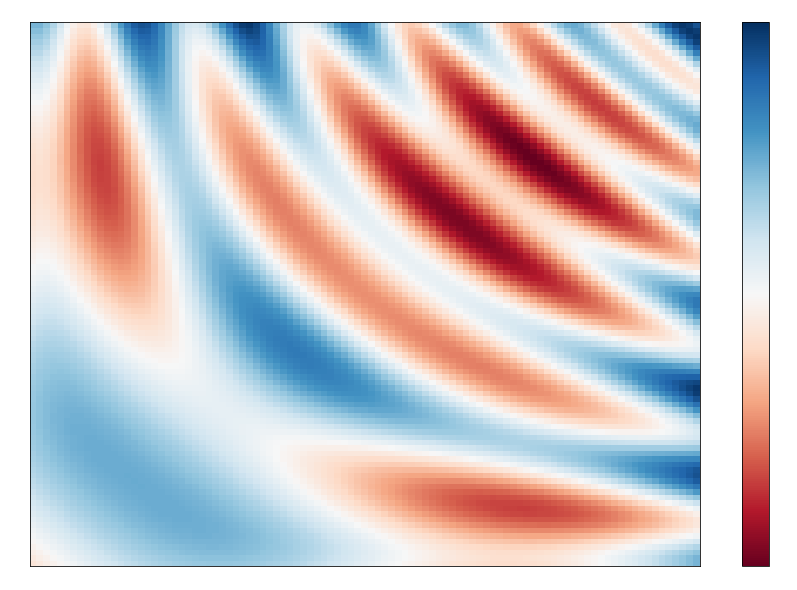

run time is : 6.837324857711792
run time is : 6.817416191101074
run time is : 5.839097738265991
run time is : 7.565099000930786
run time is : 7.9777607917785645
run time is : 7.40468430519104
run time is : 5.251982688903809
run time is : 6.44216513633728
run time is : 7.29582667350769
run time is : 7.187962770462036
run time is : 5.326204061508179
-10806.262431760992
-10814.000693362694
-10804.825617807637
-10810.34957561619
-10810.445958248092
-10808.532966562527
-10809.319630493657
-10808.466712946973
-10811.820647553122
-10808.466489321
-10807.780350554769
0.0 % complete
10.0 % complete
20.0 % complete
30.0 % complete
40.0 % complete
50.0 % complete
60.0 % complete
70.0 % complete
80.0 % complete
90.0 % complete
MSE is :  0.0140416270178185
MSE is :  0.31973943233543795
Time is :  198.47540736198425


KeyboardInterrupt: 

In [23]:
for i in range(len(dlist)):
    
    p=dlist[i]
    np.random.seed(8750)

    L = np.zeros((nmodel,ntrial,p))
    Lambda = np.zeros((nmodel,ntrial,p))
    Preds = np.zeros((nmodel,ntrial,ntest))
    MSE_F = np.zeros((nmodel, ntrial))
    MSE_Y = np.zeros((nmodel, ntrial))
    Train_time = np.zeros((nmodel, ntrial))
    Test_time = np.zeros((nmodel, ntrial))
    TPR = np.zeros((nmodel, ntrial))
    PPV = np.zeros((nmodel, ntrial))

    """
    Looping over iterations of data draws
    """
    for j in range(ntrial): 
        np.random.seed(j) # Setting seed to draw data
                   
        """
        Drawing data to use for simulation
        """
        Y,F,X,e,sigma,select,ntrain,ntest = draw_GP.draw_parametric_sin_2d_new2(n, ntest, p-2, 0, 1, corrxz=corrxz,corrzz=corrzz, r2=r2, lin=lin, block_corr = block_corr)

        X = (X-X[:ntrain].mean(0))/X[:ntrain].var(0)**0.5
        
        Xtrain = X[:ntrain, :]
        ytrain = Y[:ntrain]
        Xtest = X[ntrain:, :]
        ytest = Y[ntrain:]
        ftest = F[ntrain:]

        """
        Initialising model weight vector
        """
        weights = np.zeros(11)
        
        """
        BMA (256)
        """
        m=0
        t = time.time()

        # Running algorithm
        #testing_algorithm = partial(diagnostics.get_pred_posterior_GP_NN,reg = 0.01 ,kern = kern, grad_kern = grad_kern, latents = True, pred_selected = True, post_var = False, NN=nns, print_=False)
        m =0
        t = time.time()

        # Running algorithm
        testing_algorithm = partial(diagnostics.get_pred_posterior_GP_NN,reg = 0.01 ,kern = kern, grad_kern = grad_kern, latents = True, pred_selected = True, post_var = False, NN=nns, print_=True, fraction = test_fraction)
        hyper_vals = [1e+4*scale_values,1e-4*scale_values,np.linspace(0,10,11).astype(int)]
        hyper_arg = ["v0","v1", "seed"]
        best_pair, selections, losses, Results = fit.hyper_opt_SSGP(
                                            ytrain, Xtrain, fit.VB_EM_GP_SS, testing_algorithm, hyper_arg, hyper_vals, method =  "ML", folds = 5, metric = "elbo", 
                                            training_args=["store_ls", "print_GP_fit", "nn_fraction","final_ELBO_sample", "v0", "seed", "iter_remove", "print_VBEM", "learn_rate", "subsample", "sampling_strat", "min_VBEM_iter","init_GP_iter", "max_VBEM_iter", "GP_fit_tol", "VBEM_tol", "learn_rate_mult"], 
                                            training_arg_vals=[False, False,nn_fraction, 0,                 spike, i,        True,          False,      learn_rate,    int(minibatch),   sampling_strat ,  min_VBEM_iter, gp_iters,  max_VBEM_iter ,           1e-5,         0.1/p, learn_rate_mult])

        Train_time[m,j]= time.time()-t
        t1 = time.time()

        # Getting log predictives
        log_predictives = np.zeros(len(Results))
        for k in np.where(selections!=0)[0]:
            log_predictives[k] =  diagnostics.get_pred_posterior_GP_NN_CV(ytrain,Xtrain,Results[k],0.01,kern,NN=64, fraction=1,post_var=True, print_=False, use_tree=True, leaf_size=100, seed=0)
            print(log_predictives[k])
        log_predictives[np.where(selections==0)[0]]=np.min(log_predictives)-1000
        
        # getting weights
        min_loss = np.max(log_predictives)
        weights = np.exp(log_predictives - min_loss)*(np.abs(log_predictives - min_loss)<=500)
        weights = weights/weights.sum()

        # getting marginal posteriors
        Lmbda = np.zeros((len(Results), p))
        Ls = np.zeros((len(Results), p))
        for k in range(len(Results)):
            Lmbda[k] = Results[k][3]
            Ls[k] = np.abs(Results[k][0][0])         
        PIP = Lmbda.T @ weights
        l = Ls.T @ weights
        
        log_predictive_time = time.time()-t1

        # getting predictions
        BMA_preds = diagnostics.get_BMA_predictions(ytrain,Xtrain,Xtest,testing_algorithm, Results,weights, MC_samples=MC)
        Test_time[m,j] = time.time()-t1
        L[m,j,:] = l
        Lambda[m,j,:] = PIP
        Preds[m,j,:] = BMA_preds[0].reshape(ntest,)
        MSE_F[m,j] = (np.abs(BMA_preds[0]-ftest)**2).mean()
        MSE_Y[m,j] = (np.abs(BMA_preds[1]-ytest)**2).mean()
        L[m,j,:] = l
        Lambda[m,j,:] = PIP
        print("MSE is : ", MSE_F[m,j])
        print("MSE is : ", MSE_Y[m,j])
        print("Time is : ", Train_time[m,j]+ Test_time[m,j])
        
        """
        BMA (128)
        """
        m+=1
        t = time.time()

        # Running algorithm
        testing_algorithm = partial(diagnostics.get_pred_posterior_GP_NN,reg = 0.01 ,kern = kern, grad_kern = grad_kern, latents = True, pred_selected = True, post_var = False, NN=nns, print_=True, fraction = test_fraction)
        hyper_vals = [1e+4*scale_values,1e-4*scale_values,np.linspace(0,10,11).astype(int)]
        hyper_arg = ["v0","v1", "seed"]
        best_pair, selections, losses, Results = fit.hyper_opt_SSGP(
                                            ytrain, Xtrain, fit.VB_EM_GP_SS, testing_algorithm, hyper_arg, hyper_vals, method =  "ML", folds = 5, metric = "elbo", 
                                            training_args=["nn_fraction","final_ELBO_sample", "v0", "seed", "iter_remove", "print_VBEM", "learn_rate", "subsample", "sampling_strat", "min_VBEM_iter","init_GP_iter", "max_VBEM_iter", "GP_fit_tol", "VBEM_tol", "learn_rate_mult"], 
                                            training_arg_vals=[nn_fraction, 0, spike, i,        True,          False,      learn_rate,    int(minibatch/2),    sampling_strat ,  min_VBEM_iter, gp_iters,  max_VBEM_iter ,           1e-5,         0.1/p, learn_rate_mult])

        Train_time[m,j]= time.time()-t
        t1 = time.time()
        
        # Getting log predictives
        log_predictives = np.zeros(len(Results))
        for k in np.where(selections!=0)[0]:
            log_predictives[k] =  diagnostics.get_pred_posterior_GP_NN_CV(ytrain,Xtrain,Results[k],0.01,kern,NN=64, fraction=n**-0.5,post_var=True, print_=False, use_tree=False, leaf_size=100, seed=0)
            print(log_predictives[k])
        log_predictives[np.where(selections==0)[0]]=np.min(log_predictives)-1000
        
        # getting weights
        min_loss = np.max(log_predictives)
        weights = np.exp(log_predictives - min_loss)*(np.abs(log_predictives - min_loss)<=500)
        weights = weights/weights.sum()

        # getting marginal posteriors
        Lmbda = np.zeros((len(Results), p))
        Ls = np.zeros((len(Results), p))
        for k in range(len(Results)):
            Lmbda[k] = Results[k][3]
            Ls[k] = np.abs(Results[k][0][0])         
        PIP = Lmbda.T @ weights
        l = Ls.T @ weights

        # getting predictions
        BMA_preds = diagnostics.get_BMA_predictions(ytrain,Xtrain,Xtest,testing_algorithm, Results,weights, MC_samples=MC)
        Test_time[m,j] = time.time()-t1 + log_predictive_time
        L[m,j,:] = l
        Lambda[m,j,:] = PIP
        Preds[m,j,:] = BMA_preds[0].reshape(ntest,)
        MSE_F[m,j] = (np.abs(BMA_preds[0]-ftest)**2).mean()
        MSE_Y[m,j] = (np.abs(BMA_preds[1]-ytest)**2).mean()
        L[m,j,:] = l
        Lambda[m,j,:] = PIP
        print("MSE is : ", MSE_F[m,j])
        print("MSE is : ", MSE_Y[m,j])
        print("Time is : ", Train_time[m,j]+ Test_time[m,j])
        
        """
        BMA (64)
        """
        m+=1
        t = time.time()

        # Running algorithm
        testing_algorithm = partial(diagnostics.get_pred_posterior_GP_NN,reg = 0.01 ,kern = kern, grad_kern = grad_kern, latents = True, pred_selected = True, post_var = False, NN=nns, print_=True, fraction = test_fraction)
        hyper_vals = [1e+4*scale_values,1e-4*scale_values,np.linspace(0,10,11).astype(int)]
        hyper_arg = ["v0","v1", "seed"]
        best_pair, selections, losses, Results = fit.hyper_opt_SSGP(
                                            ytrain, Xtrain, fit.VB_EM_GP_SS, testing_algorithm, hyper_arg, hyper_vals, method =  "ML", folds = 5, metric = "elbo", 
                                            training_args=["nn_fraction", "final_ELBO_sample", "v0", "seed", "iter_remove", "print_VBEM", "learn_rate", "subsample", "sampling_strat", "min_VBEM_iter","init_GP_iter", "max_VBEM_iter", "GP_fit_tol", "VBEM_tol", "learn_rate_mult"], 
                                            training_arg_vals=[nn_fraction, 0, spike, i,    True,          False,      learn_rate,    int(minibatch/4),    sampling_strat ,  min_VBEM_iter, gp_iters,  max_VBEM_iter ,           1e-5,         0.1/p, learn_rate_mult])

        Train_time[m,j]= time.time()-t
        t1 = time.time()

        
        # Getting log predictives
        log_predictives = np.zeros(len(Results))
        for k in np.where(selections!=0)[0]:
            log_predictives[k] =  diagnostics.get_pred_posterior_GP_NN_CV(ytrain,Xtrain,Results[k],0.01,kern,NN=64, fraction=n**-0.5,post_var=True, print_=False, use_tree=False, leaf_size=100, seed=0)
            print(log_predictives[k])
        log_predictives[np.where(selections==0)[0]]=np.min(log_predictives)-1000
        
        # getting weights
        min_loss = np.max(log_predictives)
        weights = np.exp(log_predictives - min_loss)*(np.abs(log_predictives - min_loss)<=500)
        weights = weights/weights.sum()

        # getting marginal posteriors
        Lmbda = np.zeros((len(Results), p))
        Ls = np.zeros((len(Results), p))
        for k in range(len(Results)):
            Lmbda[k] = Results[k][3]
            Ls[k] = np.abs(Results[k][0][0])         
        PIP = Lmbda.T @ weights
        l = Ls.T @ weights
        
        # getting predictions
        BMA_preds = diagnostics.get_BMA_predictions(ytrain,Xtrain,Xtest,testing_algorithm, Results,weights, MC_samples=MC)
        Test_time[m,j] = time.time()-t1+log_predictive_time
        L[m,j,:] = l
        Lambda[m,j,:] = PIP
        Preds[m,j,:] = BMA_preds[0].reshape(ntest,)
        MSE_F[m,j] = (np.abs(BMA_preds[0]-ftest)**2).mean()
        MSE_Y[m,j] = (np.abs(BMA_preds[1]-ytest)**2).mean()
        L[m,j,:] = l
        Lambda[m,j,:] = PIP
        print("MSE is : ", MSE_F[m,j])
        print("MSE is : ", MSE_Y[m,j])
        print("Time is : ", Train_time[m,j]+ Test_time[m,j])
        
    """
    Storing results in master lists
    """

    Lengthscales.append(L)
    Lambdas.append(Lambda)
    Predictions.append(Preds)
    MSerrors_Y.append(MSE_Y)
    MSerrors_F.append(MSE_F)
    Training_times.append(Train_time)
    Testing_times.append(Test_time)

In [24]:
for i in range(len(Results)):
    print(Results[i][0][0][:10])
    

[3.47634732 3.66066191 0.         0.         0.         0.
 0.         0.         0.         0.        ]
[-3.68006869  3.72562027  0.          0.          0.          0.
  0.          0.          0.0161475   0.        ]
[3.47079944 3.68743199 0.         0.         0.         0.
 0.         0.         0.         0.        ]
[ 3.74048054 -3.7246228   0.          0.          0.          0.
  0.          0.          0.          0.        ]
[3.85081004 3.66665112 0.         0.         0.         0.
 0.         0.         0.         0.        ]
[-3.3779574   3.53829562  0.          0.          0.          0.
  0.          0.          0.          0.        ]
[3.51292232 3.51241898 0.         0.         0.         0.
 0.         0.         0.         0.        ]
[-3.88168867  3.61343776  0.          0.          0.          0.
  0.          0.          0.          0.        ]
[3.70751359 3.6073575  0.         0.         0.         0.
 0.         0.         0.         0.        ]
[3.47837114 3.6

In [ ]:
from datetime import date
Output = {"Names" : names, "L" : Lengthscales, "Lambda" : Lambdas,"Preds" : Predictions, "MSE_Y" : MSerrors_Y, "MSE_F" : MSerrors_F, "Train_time" : Training_times, "Test_time" : Testing_times}
String = "E3_{0}_SSVGP".format(
    date.today(),ntrain,ntest,dlist, corrxz, np.round(1-r2,1),minibatch,NNpred,nns, r2)
np.save(String, Output) # saving